In [1]:
%matplotlib inline

In [20]:
import os
import glob
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np

from astropy.io import fits
import astropy.wcs 
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
    
import pysynphot as S

import grizli
import grizli.fake_image

print('\n grizli version: %s' %(grizli.__version__))


 grizli version: 0.2.1-27-ga90792c


In [12]:
## Fetch current placeholder NIRISS configuration files
if not os.path.exists(os.path.join(os.getenv('GRIZLI'), 'CONF/NIRISS.F150W.conf')):
    cwd = os.getcwd()
    os.chdir(os.path.join(os.getenv('GRIZLI'), 'CONF'))
    os.system('wget http://www.stsci.edu/jwst/instruments/niriss/software-tools/wfss-simulations/niriss-wfss.tar')
    os.system('tar xvf niriss-wfss.tar cookbook/CONF')
    os.system('ln -s cookbook/CONF/NIRISS* .')

### Set up files for simulating the WFC3/IR HUDF field

In [13]:
os.chdir('/tmp/')

## Fetch WFC3/IR F140W images of the UDF
if not os.path.exists('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits'):
    url = 'https://archive.stsci.edu/missions/hlsp/xdf/'
    os.system('wget %s/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits' %(url))
    os.system('wget %s/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_wht.fits' %(url))
    
## 3D-HST photometry around the HUDF field, and an extension with best-fit photo-z SED
if not os.path.exists('udf_3dhst_cat.fits'):
    os.system('wget http://www.stsci.edu/~brammer/Grizli/Demos/udf_3dhst_cat.fits')

In [16]:
## Make an object catalog / segmentation image with photutils
sci = fits.open('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits')
wht = fits.open('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_wht.fits')
rms = 1/np.sqrt(wht[0].data)
rms[~np.isfinite(rms)] = 1000
dq = rms > 900
wcs = astropy.wcs.WCS(sci[0].header)

# Run the detection with the grizli / photutils wrapper
cat, seg = grizli.utils.detect_with_photutils(sci[0].data, err=rms, dq=dq, seg=None, 
                                              detect_thresh=1.4, npixels=6, grow_seg=3, 
                                              gauss_fwhm=2.0, gsize=3, wcs=wcs, save_detection=False, 
                                              root='udf_f140w_photutils', background=None, gain=None, 
                                              AB_zeropoint=26.452, 
                                              rename_columns={'ycentroid': 'y_flt', 'xcentroid': 'x_flt', 
                                                              'dec_icrs_centroid': 'dec', 'ra_icrs_centroid': 'ra'}, 
                                              clobber=True, verbose=True)

# code expects this columns later....
cat['NUMBER'] = cat['id']

udf_f140w_photutils: photutils.detect_sources (detect_thresh=1.4, grow_seg=3, gauss_fwhm=2.0, ZP=26.5)
udf_f140w_photutils: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
udf_f140w_photutils: photutils.source_properties - 3354 objects


In [17]:
# Get matches from 3D-HST catalog
ref_3dhst = fits.open('udf_3dhst_cat.fits')
ref_cat = Table.read(ref_3dhst[1])

gs = SkyCoord(ra=ref_cat['ra']*u.degree, dec=ref_cat['dec']*u.degree)
cat_rd = SkyCoord(ra=cat['ra'], dec=cat['dec'])

gs_idx, d2d, d3d = cat_rd.match_to_catalog_sky(gs)
has_gs_match = np.where(d2d < 2*u.arcsec)[0]

# Use 3D-HST mags because quick photutils catalog has some issues, 
# perhaps related to background subtraction
gs_mag = 25-2.5*np.log10(ref_cat['F204'])
cat['MAG_AUTO'] = gs_mag[gs_idx] 
cat.write('udf_f140w_photutils.cat', format='ascii.commented_header')

fits.writeto('udf_f140w_photutils_seg.fits', data=np.cast[int](seg), header=sci[0].header, clobber=True)

### Make fake images with NIRISS dimensions

Simulate three broad-band filters (F115W, F150W, F200W) at two orients rotated by 90 degrees.  For now, rotate the catalogs, but NIRISS will have two grisms to obtain the two orients in a single visit.

In [18]:
## Setup fake images, cendered in the UDF/XDF
ra, dec = 53.1592277508136, -27.782056346146
pa_aper = 128.589

np.random.seed(1)
# Crude exposure parameters.  Rough read noise and backgrounds coded in 
# grizli.fake_image to make some reasonable noise estimate
EXPTIME = 1.e4 # 10 ks ~ 4 HST orbits
NEXP = 10      # divided between 10 exposures

# JWST NIRISS, three filters & two orients
for filt in ['F115W', 'F150W', 'F200W']:
    for theta in [0,90]:
        h, wcs = grizli.fake_image.niriss_header(filter=filt, ra=ra, dec=dec, pa_aper=pa_aper+theta)
        print('Filter: {filter}, Background: {bg} e/s/pix, RN: {RN} e/exp'.format(filter=filt, 
                                                                                  bg=h['BACKGR'], RN=h['READN']))
        output = 'niriss_{filt}_{theta:02d}_flt.fits'.format(filt=filt, theta=theta)
        grizli.fake_image.make_fake_image(h, output=output, exptime=EXPTIME, nexp=NEXP)

Filter: F115W, Background: 0.47 e/s/pix, RN: 6 e/exp
Filter: F115W, Background: 0.47 e/s/pix, RN: 6 e/exp
Filter: F150W, Background: 0.48 e/s/pix, RN: 6 e/exp
Filter: F150W, Background: 0.48 e/s/pix, RN: 6 e/exp
Filter: F200W, Background: 0.44 e/s/pix, RN: 6 e/exp
Filter: F200W, Background: 0.44 e/s/pix, RN: 6 e/exp


#### Initialize a `grizli.multifit.GroupFLT` object and simulate spectra

In [21]:
# Load GroupFLT for simulation, NB: input files are just noise
sim = grizli.multifit.GroupFLT(grism_files=glob.glob('niriss_*flt.fits'), direct_files=[], 
                               ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits', 
                               seg_file='udf_f140w_photutils_seg.fits', catalog='udf_f140w_photutils.cat',
                               cpu_count=0, pad=200)

Image cutout: x=slice(609, 4986, None), y=slice(997, 5250, None) [Out of range]
niriss_F115W_90_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Image cutout: x=slice(609, 4984, None), y=slice(997, 5250, None) [Out of range]
Image cutout: x=slice(609, 4984, None), y=slice(997, 5250, None) [Out of range]
Image cutout: x=slice(609, 4986, None), y=slice(997, 5250, None) [Out of range]
niriss_F115W_00_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
niriss_F150W_90_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Image cutout: x=slice(609, 4986, None), y=slice(997, 5250, None) [Out of range]
niriss_F150W_00_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Image cutout: x=slice(609, 4984, None), y=slice(997, 5250, None) [Out of range]
niriss_F200W_00_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
niriss_F200W_90_flt.fits / blot reference hlsp_xdf

In [22]:
# First pass, flat continuum
sim.compute_full_model(mag_limit=27)

niriss_F115W_00_flt.fits: _compute_model Done
niriss_F115W_90_flt.fits: _compute_model Done
niriss_F150W_00_flt.fits: _compute_model Done
niriss_F150W_90_flt.fits: _compute_model Done
niriss_F200W_00_flt.fits: _compute_model Done
niriss_F200W_90_flt.fits: _compute_model Done
Models computed - 55.05 sec.


In [23]:
# Compute model spectra for 3D-HST matches from photo-z templates
detection_bp = S.ObsBandpass('wfc3,ir,f140w')
for ix in has_gs_match:
    templ = ref_3dhst['WAVE'].data*(1+ref_cat['zbest'][gs_idx[ix]])
    tempf = ref_3dhst['FLAMBDA'].data[gs_idx[ix],:]
    # Needs to be normalized to unity in the detection band
    spec = S.ArraySpectrum(wave=templ, flux=tempf, waveunits='angstroms', fluxunits='flam')
    spec = spec.renorm(1., 'flam', detection_bp)

    id = cat['id'][ix]
    #print(id)
    sim.compute_single_model(id, mag=cat['MAG_AUTO'][ix], size=-1, store=False, 
                             spectrum_1d=[spec.wave, spec.flux], get_beams=None, in_place=True)

In [26]:
# Update SCI extension of the fake FLT images with the models just computed
for flt in sim.FLTs:
    print('Update', flt.grism_file)
    orig_flt = fits.open(flt.grism_file, mode='update')
    orig_flt['SCI'].data += flt.model[flt.pad:-flt.pad, flt.pad:-flt.pad]
    orig_flt.flush()

Update niriss_F115W_00_flt.fits
Update niriss_F115W_90_flt.fits
Update niriss_F150W_00_flt.fits
Update niriss_F150W_90_flt.fits
Update niriss_F200W_00_flt.fits
Update niriss_F200W_90_flt.fits


### Analyze simulated data
Now use a `grizli.multifit.GroupFLT` object to analyze the data as if they were real observations.

In [27]:
# Now reload for fitting
grp = grizli.multifit.GroupFLT(grism_files=glob.glob('niriss_*flt.fits'), direct_files=[], 
                               ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits',
                               seg_file='udf_f140w_photutils_seg.fits',
                               catalog='udf_f140w_photutils.cat',
                               cpu_count=0, pad=200)

Image cutout: x=slice(609, 4986, None), y=slice(997, 5250, None) [Out of range]
niriss_F150W_90_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Image cutout: x=slice(609, 4984, None), y=slice(997, 5250, None) [Out of range]
Image cutout: x=slice(609, 4984, None), y=slice(997, 5250, None) [Out of range]
niriss_F115W_00_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
niriss_F150W_00_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
Image cutout: x=slice(609, 4984, None), y=slice(997, 5250, None) [Out of range]
niriss_F200W_00_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Image cutout: x=slice(609, 4986, None), y=slice(997, 5250, None) [Out of range]
niriss_F115W_90_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hud

In [28]:
# First pass contamination model, flat continuum
grp.compute_full_model(mag_limit=26)

niriss_F115W_00_flt.fits: _compute_model Done
niriss_F115W_90_flt.fits: _compute_model Done
niriss_F150W_00_flt.fits: _compute_model Done
niriss_F150W_90_flt.fits: _compute_model Done
niriss_F200W_00_flt.fits: _compute_model Done
niriss_F200W_90_flt.fits: _compute_model Done
Models computed - 48.35 sec.


In [29]:
# Refine the (polynomial) continuum model for brighter objects
grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)

#### Fit redshifts and emission lines of a single object

In [ ]:
## Fit parameters
pzfit, pspec2, pline = grizli.multifit.get_redshift_fit_defaults()

# Redshift fit
pzfit ['zr'] = [0.5, 2.4]
pzfit['dz'] = [0.005, 0.0005]

# Drizzled line maps
pline = {'kernel': 'square', 'pixfrac': 0.8, 'pixscale': 0.06, 'size': 10}

# Full rectified 2D spectrum
pspec2 = {'NY': 20, 'dlam': 50, 'spatial_scale': 1}

First iteration: z_best=2.3383

 Zoom iteration: z_best=2.3420

Drizzle line -> Ha   (0.73 0.05)
Drizzle line -> OIII (0.45 0.12)
Drizzle line -> Hb   (0.19 0.05)


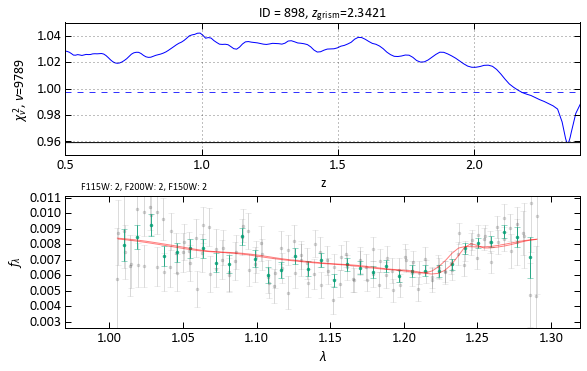

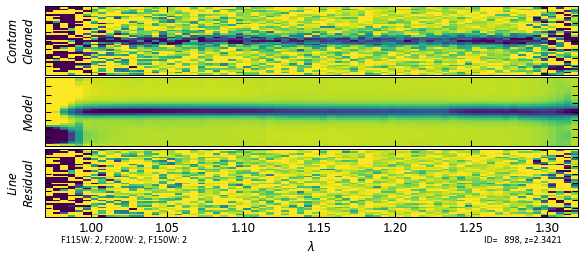

In [38]:
from importlib import reload
reload(grizli.multifit)

## emission line object
id = 898 # ID in the detection catalog / segm image

# Extract spectrum cutouts from individual FLTs
beams = grp.get_beams(id, size=40)

# Put them in a `MultiBeam` object
mb = grizli.multifit.MultiBeam(beams, fcontam=1, group_name='niriss-udf')

# Run the redshift fit and generate the emission line map
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

fit, fig, fig2, hdu2, hdu_line = out